# Initializiation

In [1]:
%load_ext autoreload
%autoreload 2

import pymc3 as pm
import numpy as np
import math as m
import matplotlib.pyplot as plt
import dive 
import deerlab as dl
from scipy.io import loadmat
from theano import tensor as T
from theano.tensor import nlinalg as tnp
from theano.tensor import slinalg as snp
from scipy.linalg import sqrtm
import deerlab as dl
from pymc3.step_methods.arraystep import BlockedStep
import pymc3 as pm
import scipy as sp
from pymc3.distributions.transforms import log

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Load data

In [2]:
loaded_data = np.genfromtxt("../../data/2g_Pid-3223_Sid-36787.dat", skip_header = 1, delimiter = ',')
Pid = 3223
t = loaded_data[:,0]
Vexp = loaded_data[:,1]

In [3]:
# prune time trace
skip = 1
tprune = t[::skip]
Vprune = Vexp[::skip]

# Display Data

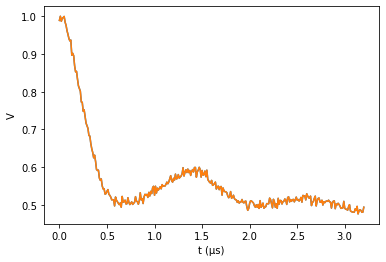

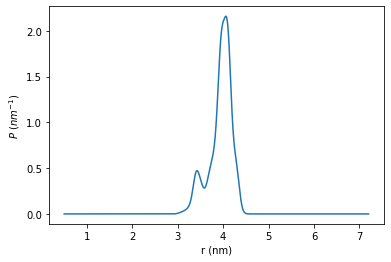

In [4]:
plt.plot(t, Vexp, tprune, Vprune)
plt.xlabel('t (µs)')
plt.ylabel('V')
plt.show()

P0s = loadmat('..\..\data\edwards_testset\distributions_2LZM.mat')['P0']
rref = np.squeeze(loadmat('..\..\data\edwards_testset\distributions_2LZM.mat')['r0'])
Pref = P0s[Pid-1,:]

plt.plot(rref, Pref)
plt.xlabel('r (nm)')
plt.ylabel(r'$P~(nm^{-1})$')
plt.show()



# Setup P sampler

In [5]:
# kernel regularization operator
r = np.linspace(2,8,100)
dr = r[1]-r[0]

K0 = dl.dipolarkernel(tprune,r,integralop=False)   # kernel matrix
L = dl.regoperator(np.linspace(1,len(r),len(r)), 2)
LtL = np.matmul(np.transpose(L),L)
K0tK0 = np.matmul(np.transpose(K0),K0)

# parameters for delta distribution
a0 = 0.01
b0 = 1e-6

In [6]:
class SamplePfromV(BlockedStep):
    def __init__(self, var, K0, LtL, t, V, r, delta, sigma, k, lamb, V0):
            self.vars = [var]
            self.var = var
            
            # precalculated values
            self.K0 = K0
            self.LtL = LtL
            self.V = V
            self.r = r
            self.t = t

            # random variables
            self.delta = delta
            self.sigma = sigma
            self.k = k
            self.lamb = lamb
            self.V0 = V0

    def step(self, point: dict):
        # transform parameters
        sigma =  dive.undo_transform(point,self.sigma.transformed.name)
        tau = 1/(sigma**2)

        delta = dive.undo_transform(point,self.delta.name)
        k = dive.undo_transform(point,self.k.transformed.name)
        
        lamb = dive.undo_transform(point,self.lamb.transformed.name)
        V0 = dive.undo_transform(point,self.V0.transformed.name) 

        # k = 0.05
        # lamb = 0.5

        print('V0: ' + str(V0), 'delta: ' + str(delta), 'k: ' + str(k), 'lamb: ' + str(lamb), 'sigma: ' + str(sigma))
        # calculate some values
        dr = self.r[1] - self.r[0]

        # Background
        B = dl.bg_exp(self.t,k) 

        # Kernel
        Kintra = (1-lamb)+lamb*self.K0
        K = Kintra * B[:, np.newaxis]
        K = V0*K*dr

        # KtXs
        KtK = np.matmul(np.transpose(K),K)
        KtV = np.matmul(np.transpose(K),self.V) 

        tauKtV = tau*KtV
        invSigma = tau*KtK + delta*self.LtL
        
        newpoint = point.copy()
        Pdraw = dive.randP(tauKtV,invSigma)
        Pdraw =  Pdraw / np.sum(Pdraw) / dr
        newpoint[self.var.name] = Pdraw

        return newpoint

# Gamma distribution for delta prior, Normal (1, lg(alpha)) for P prior - Bad initial energy

## Model definition, sampling, and error message

In [13]:
# Model definition
with pm.Model() as model00:
    # Noise --------------------------------------------------------------
    sigma = pm.Gamma('sigma', alpha=0.7, beta=2)
    tau = pm.Deterministic('tau',1/(sigma**2))

    # Regularization parameter -------------------------------------------
    delta = pm.Gamma('delta', alpha=a0, beta=b0, transform = None)
    lg_alpha = pm.Deterministic('lg_alpha', np.log10(np.sqrt(delta/tau)) )

    # Time Domain --------------------------------------------------------
    lamb = pm.Beta('lamb', alpha=1.3, beta=2.0)
    V0 = pm.Bound(pm.Normal, lower=0.0)('V0', mu=1, sigma=0.2)

    # Background ---------------------------------------------------------
    k = pm.Gamma('k', alpha=0.5, beta=2)
    B = dl.bg_exp(tprune, k)

    # Distance distribution ----------------------------------------------
    P = pm.Normal("P", mu = 1, sigma = lg_alpha, shape = len(r), transform = None)       

    # Calculate matrices and operators -----------------------------------
    Kintra = (1-lamb) + lamb*K0
    B_ = T.transpose( T.tile(B,(len(r),1)) )
    K = V0*Kintra*B_*dr

    # Time domain model ---------------------------------------------------
    Vmodel = pm.math.dot(K,P)

    # Likelihood ----------------------------------------------------------
    pm.Normal('V',mu = Vmodel, sigma = sigma, observed = Vprune)

In [14]:
with model00:
    step_P = SamplePfromV(P, K0, LtL, tprune, Vprune, r, delta, sigma, k, lamb, V0)
    step_delta = dive.randDelta(delta, a0, b0, L, P)
    trace = pm.sample(step = [step_P, step_delta], chains=1, cores=1, draws=5000, tune= 1000, return_inferencedata=False, progressbar = True, init ='adapt_diag', random_seed=345)

Sequential sampling (1 chains in 1 job)
CompoundStep
>SamplePfromV: [P]
>randDelta: [delta]
>NUTS: [k, V0, lamb, sigma]


V0: 1.0 delta: 10000.0 k: 0.25 lamb: 0.393939393939394 sigma: 0.3499999999999999
V0: 1.0 delta: 15541.177374367166 k: 0.25 lamb: 0.393939393939394 sigma: 0.3499999999999999
V0: 1.0 delta: 21204.99796918914 k: 0.25 lamb: 0.393939393939394 sigma: 0.3499999999999999
V0: 1.1622497035614916 delta: 45123.89438117714 k: 0.24496474474535754 lamb: 0.39429564396629246 sigma: 0.2794148723432358
V0: 1.1622497035614916 delta: 51937.89731561822 k: 0.24496474474535754 lamb: 0.39429564396629246 sigma: 0.2794148723432358
V0: 1.165789385789375 delta: 72964.84268940438 k: 0.24119053412471955 lamb: 0.3929589182548446 sigma: 0.2744671608590152
V0: 1.1791741968315688 delta: 95005.32378620996 k: 0.20340321750691714 lamb: 0.3953953775231166 sigma: 0.21881069272925371
V0: 1.172089704150422 delta: 91595.811240365 k: 0.19684925724431704 lamb: 0.393031009076976 sigma: 0.21123422160636687
V0: 1.179611397301844 delta: 82877.95537060888 k: 0.19995332081176784 lamb: 0.3981817237473493 sigma: 0.15465675563306622
V0: 1

SamplingError: Bad initial energy

## Investigate delta distribution

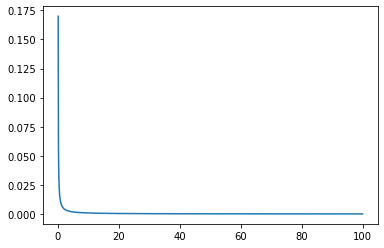

In [59]:
import scipy.stats as stats 
a0 = 0.01
b0 = 1e-6
x = np.linspace (0, 100, 2000)
y1 = stats.gamma.pdf(x, a=a0, scale=1/b0)
plt.plot(x, y1)
plt.xlim = ([0,10])
plt.show();

# Uniform delta prior, Normal(1, lg(alpha)) P prior - Bad initial energy

In [1]:
# Model definition
with pm.Model() as model10:
    # Noise --------------------------------------------------------------
    sigma = pm.Gamma('sigma', alpha=0.7, beta=2)
    tau = pm.Deterministic('tau',1/(sigma**2))

    # Regularization parameter -------------------------------------------
    delta = pm.Uniform('delta', lower= 0, upper = 1e20, transform = None)
    lg_alpha = pm.Deterministic('lg_alpha', np.log10(np.sqrt(delta/tau)) )

    # Time Domain --------------------------------------------------------
    lamb = pm.Beta('lamb', alpha=1.3, beta=2.0)
    V0 = pm.Bound(pm.Normal, lower=0.0)('V0', mu=1, sigma=0.2)

    # Background ---------------------------------------------------------
    k = pm.Gamma('k', alpha=0.5, beta=2)
    B = dl.bg_exp(tprune, k)

    # Distance distribution ----------------------------------------------
    P = pm.Normal("P", mu = 1, sigma = lg_alpha, shape = len(r), transform = None)     

    # Calculate matrices and operators -----------------------------------
    Kintra = (1-lamb) + lamb*K0
    B_ = T.transpose( T.tile(B,(len(r),1)) )
    K = V0*Kintra*B_*dr

    # Time domain model ---------------------------------------------------
    Vmodel = pm.math.dot(K,P)

    # Likelihood ----------------------------------------------------------
    pm.Normal('V',mu = Vmodel, sigma = sigma, observed = Vprune)

NameError: name 'pm' is not defined

In [71]:
with model10:
    step_P = SamplePfromV(P, K0, LtL, tprune, Vprune, r, delta, sigma, k, lamb, V0)
    step_delta = dive.randDelta(delta, a0, b0, L, P)
    trace = pm.sample(step = [step_P, step_delta], chains=1, cores=1, draws=5000, tune= 1000, return_inferencedata=False, progressbar = True, init ='adapt_diag',start = {'delta': 20000})

Sequential sampling (1 chains in 1 job)
CompoundStep
>SamplePfromV: [P]
>randDelta: [delta]
>NUTS: [k, V0, lamb, sigma]


V0: 1.0 delta: 20000 k: 0.25 lamb: 0.393939393939394 sigma: 0.3499999999999999
V0: 1.0 delta: 42215.38041048953 k: 0.25 lamb: 0.393939393939394 sigma: 0.3499999999999999
V0: 1.0 delta: 64415.95785356188 k: 0.25 lamb: 0.393939393939394 sigma: 0.3499999999999999
V0: 0.9837193439342242 delta: 72862.09605128637 k: 0.25372368824376007 lamb: 0.3871406696112384 sigma: 0.3645249242942369
V0: 1.0441192035981395 delta: 96917.45506073658 k: 0.2436857672598927 lamb: 0.3757869699987965 sigma: 0.5100068488218531
V0: 1.0560406116787706 delta: 91663.6431918911 k: 0.1689338020423025 lamb: 0.08400116504176071 sigma: 0.5109233318780353
V0: 1.2722261683330074 delta: 40488.075537379955 k: 0.001661964203256961 lamb: 0.209337266186787 sigma: 0.5044581038534875
V0: 1.329467662335304 delta: 17042.96046577689 k: 0.0015750834533219333 lamb: 0.21732662331134542 sigma: 0.4923673183724119
V0: 1.1402483531669936 delta: 2836.1886002529022 k: 0.0024185290053722517 lamb: 0.22477086972584367 sigma: 0.519419844679435
V0:

SamplingError: Bad initial energy

# Gamma for delta prior, Uniform for P prior - success

In [72]:
# Model definition
with pm.Model() as model01:
    # Noise --------------------------------------------------------------
    sigma = pm.Gamma('sigma', alpha=0.7, beta=2)
    tau = pm.Deterministic('tau',1/(sigma**2))

    # Regularization parameter -------------------------------------------
    delta = pm.Gamma('delta', alpha=a0, beta=b0, transform = None)
    lg_alpha = pm.Deterministic('lg_alpha', np.log10(np.sqrt(delta/tau)) )

    # Time Domain --------------------------------------------------------
    lamb = pm.Beta('lamb', alpha=1.3, beta=2.0)
    V0 = pm.Bound(pm.Normal, lower=0.0)('V0', mu=1, sigma=0.2)

    # Background ---------------------------------------------------------
    k = pm.Gamma('k', alpha=0.5, beta=2)
    B = dl.bg_exp(tprune, k)

    # Distance distribution ----------------------------------------------
    P = pm.Uniform("P", lower= 0, upper = 1000, shape = len(r), transform = None)            

    # Calculate matrices and operators -----------------------------------
    Kintra = (1-lamb) + lamb*K0
    B_ = T.transpose( T.tile(B,(len(r),1)) )
    K = V0*Kintra*B_*dr

    # Time domain model ---------------------------------------------------
    Vmodel = pm.math.dot(K,P)

    # Likelihood ----------------------------------------------------------
    pm.Normal('V',mu = Vmodel, sigma = sigma, observed = Vprune)

In [73]:
with model01:
    step_P = SamplePfromV(P, K0, LtL, tprune, Vprune, r, delta, sigma, k, lamb, V0)
    step_delta = dive.randDelta(delta, a0, b0, L, P)
    trace = pm.sample(step = [step_P, step_delta], chains=1, cores=1, draws=5000, tune= 1000, return_inferencedata=False, progressbar = True, init ='adapt_diag',start = {'delta': 20000})

Sequential sampling (1 chains in 1 job)
CompoundStep
>SamplePfromV: [P]
>randDelta: [delta]
>NUTS: [k, V0, lamb, sigma]


V0: 1.0 delta: 20000 k: 0.25 lamb: 0.393939393939394 sigma: 0.3499999999999999
V0: 1.0 delta: 43386.168263381616 k: 0.25 lamb: 0.393939393939394 sigma: 0.3499999999999999
V0: 1.0 delta: 60202.59552194598 k: 0.25 lamb: 0.393939393939394 sigma: 0.3499999999999999
V0: 1.0110428815914934 delta: 63686.75110080358 k: 0.28784829491977765 lamb: 0.39009671136420265 sigma: 0.5291253802497922
V0: 1.0371948063949363 delta: 90101.54791209954 k: 0.4595502687868046 lamb: 0.40468792279006294 sigma: 0.5279312411521367
V0: 1.0259250431633835 delta: 117480.85516800427 k: 0.500332707038611 lamb: 0.3987364736430331 sigma: 0.6244858984528024
V0: 0.9553306223420697 delta: 264901.3463968037 k: 0.03338577774620828 lamb: 0.47420667965501595 sigma: 0.5252442638559928
V0: 0.9553306223420697 delta: 251441.73267915714 k: 0.03338577774620828 lamb: 0.47420667965501595 sigma: 0.5252442638559928
V0: 0.9455173000573102 delta: 330546.5448389929 k: 0.05669064892294416 lamb: 0.43537424950933185 sigma: 0.5921257908391856
V0

Sampling 1 chain for 1_000 tune and 5_000 draw iterations (1_000 + 5_000 draws total) took 444 seconds.
There were 108 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


arviz - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
k,0.251,0.339,0.000,0.891,0.006,0.005,1956.0,1400.0,NaN
λ,0.390,0.232,0.003,0.785,0.004,0.003,2507.0,2063.0,NaN
V₀,0.999,0.200,0.624,1.385,0.005,0.003,1855.0,1342.0,NaN
σ,0.580,0.045,0.499,0.668,0.001,0.001,2725.0,2421.0,NaN
δ,489867.920,878124.094,1.035,2175846.178,42639.216,30171.237,170.0,231.0,NaN
lg(α),2.159,0.612,1.012,3.103,0.058,0.041,168.0,225.0,NaN


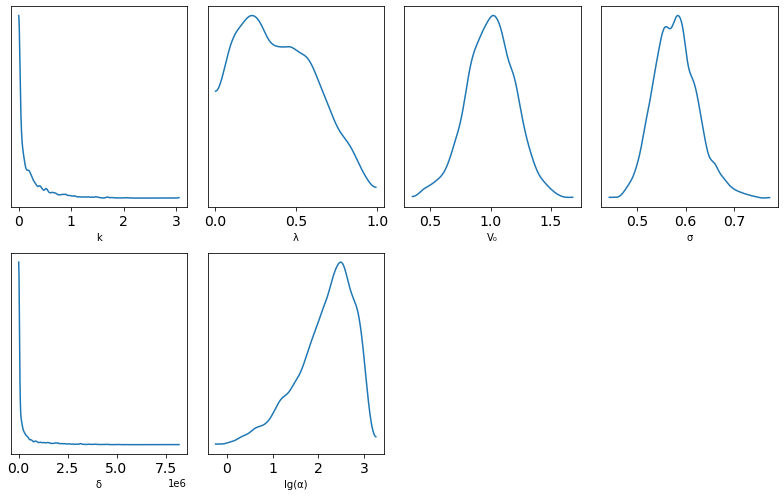

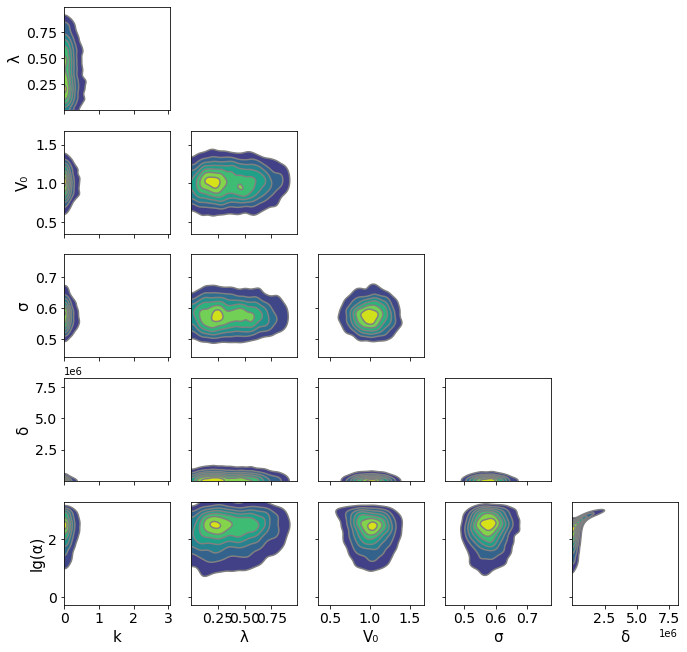

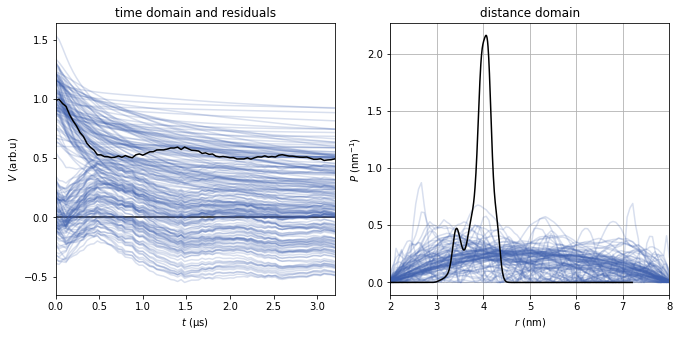

In [74]:
model_pars = {'K0': K0, 'L': L, 'LtL': LtL, 'K0tK0': K0tK0, "r": r, 'a_delta': a0, 'b_delta': b0, 'a_tau': a0, 'b_tau': b0}
    

divemodel = {'model_graph': model01, 'model_pars': model_pars, 't': tprune, 'Vexp': Vprune}


dive.summary(trace,divemodel, Pid = 3223)

# Uniform for delta prior, Uniform for P prior - success

In [63]:
# Model definition
with pm.Model() as model11:
    # Noise --------------------------------------------------------------
    sigma = pm.Gamma('sigma', alpha=0.7, beta=2)
    tau = pm.Deterministic('tau',1/(sigma**2))

    # Regularization parameter -------------------------------------------
    delta = pm.Uniform('delta', lower= 0, upper = 1e20, transform = None)
    lg_alpha = pm.Deterministic('lg_alpha', np.log10(np.sqrt(delta/tau)) )

    # Time Domain --------------------------------------------------------
    lamb = pm.Beta('lamb', alpha=1.3, beta=2.0)
    V0 = pm.Bound(pm.Normal, lower=0.0)('V0', mu=1, sigma=0.2)

    # Background ---------------------------------------------------------
    k = pm.Gamma('k', alpha=0.5, beta=2)
    B = dl.bg_exp(tprune, k)

    # Distance distribution ----------------------------------------------
    # P = pm.MvNormal("P", mu = 0, sigma = delta/2*LtL, shape = len(r), transform = None)
    P = pm.Uniform("P", lower= 0, upper = 1000, shape = len(r), transform = None)      

    # Calculate matrices and operators -----------------------------------
    Kintra = (1-lamb) + lamb*K0
    B_ = T.transpose( T.tile(B,(len(r),1)) )
    K = V0*Kintra*B_*dr

    # Time domain model ---------------------------------------------------
    Vmodel = pm.math.dot(K,P)

    # Likelihood ----------------------------------------------------------
    pm.Normal('V',mu = Vmodel, sigma = sigma, observed = Vprune)

In [64]:
with model11:
    step_P = SamplePfromV(P, K0, LtL, tprune, Vprune, r, delta, sigma, k, lamb, V0)
    step_delta = dive.randDelta(delta, a0, b0, L, P)
    trace = pm.sample(step = [step_P, step_delta], chains=1, cores=1, draws=5000, tune= 1000, return_inferencedata=False, progressbar = True, init ='adapt_diag',start = {'delta': 20000})

Sequential sampling (1 chains in 1 job)
CompoundStep
>SamplePfromV: [P]
>randDelta: [delta]
>NUTS: [k, V0, lamb, sigma]


V0: 1.0 delta: 20000 k: 0.25 lamb: 0.393939393939394 sigma: 0.3499999999999999
V0: 1.0 delta: 42900.445861736174 k: 0.25 lamb: 0.393939393939394 sigma: 0.3499999999999999
V0: 1.0 delta: 78935.23453161334 k: 0.25 lamb: 0.393939393939394 sigma: 0.3499999999999999
V0: 0.9455736101125046 delta: 108649.1697532042 k: 0.23583715489320012 lamb: 0.388145422470753 sigma: 0.402988880315099
V0: 1.03922988975917 delta: 201914.7190149643 k: 0.22620452136435926 lamb: 0.4026851374562224 sigma: 0.5115958638760741
V0: 1.0471726292364965 delta: 163737.54938671226 k: 0.15300359737997346 lamb: 0.5419977652589891 sigma: 0.6004233850232492
V0: 1.078812486326495 delta: 304002.82249176473 k: 0.01819351457430475 lamb: 0.18253227348923412 sigma: 0.6001714274751668
V0: 1.0644012812298345 delta: 128423.05187833485 k: 0.016122816979368428 lamb: 0.15774589603283068 sigma: 0.6383086093179409
V0: 1.0754937111121579 delta: 63464.53090612903 k: 0.03107738732821549 lamb: 0.49113015349904476 sigma: 0.6071536292558976
V0: 

Sampling 1 chain for 1_000 tune and 5_000 draw iterations (1_000 + 5_000 draws total) took 301 seconds.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


arviz - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
k,0.249,0.344,0.000,0.891,0.005,0.004,2485.0,1546.0,NaN
λ,0.398,0.237,0.021,0.817,0.003,0.003,4181.0,3318.0,NaN
V₀,1.005,0.194,0.633,1.347,0.003,0.002,3581.0,2642.0,NaN
σ,0.580,0.047,0.491,0.666,0.001,0.001,3155.0,3301.0,NaN
δ,494606.006,717343.140,12.780,1836503.804,40354.913,28561.613,165.0,265.0,NaN
lg(α),2.321,0.459,1.481,3.050,0.038,0.027,164.0,272.0,NaN


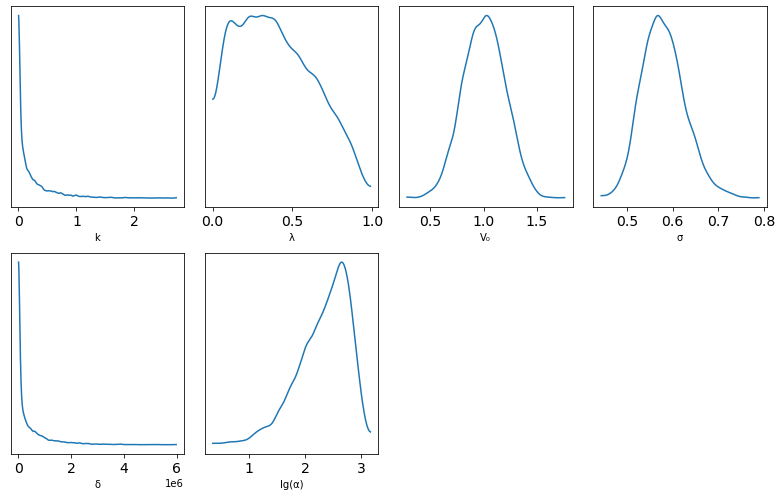

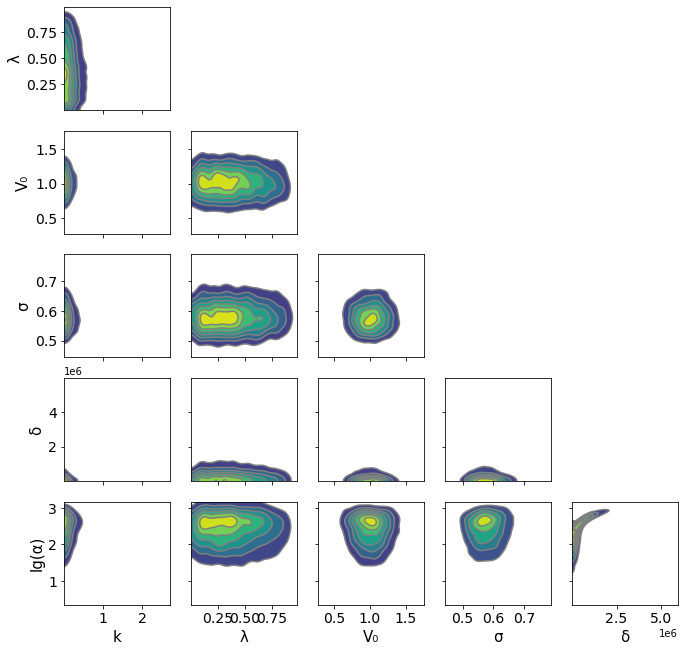

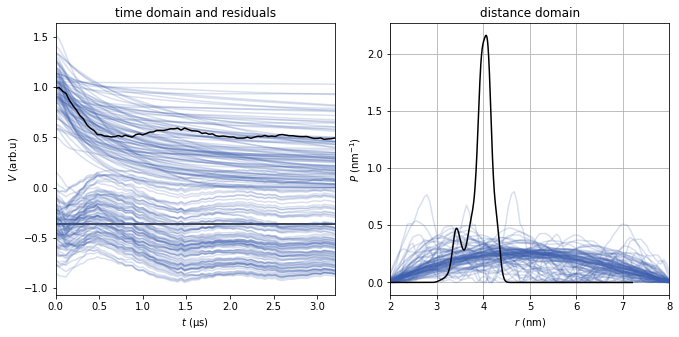

In [69]:
model_pars = {'K0': K0, 'L': L, 'LtL': LtL, 'K0tK0': K0tK0, "r": r, 'a_delta': a0, 'b_delta': b0, 'a_tau': a0, 'b_tau': b0}
    

divemodel = {'model_graph': model11, 'model_pars': model_pars, 't': tprune, 'Vexp': Vprune}


dive.summary(trace,divemodel, Pid = 3223)

# Print out Ps during 'bad initial energy' runs

In [14]:
class SamplePfromV_printP(BlockedStep):
    def __init__(self, var, K0, LtL, t, V, r, delta, sigma, k, lamb, V0):
            self.vars = [var]
            self.var = var
            
            # precalculated values
            self.K0 = K0
            self.LtL = LtL
            self.V = V
            self.r = r
            self.t = t

            # random variables
            self.delta = delta
            self.sigma = sigma
            self.k = k
            self.lamb = lamb
            self.V0 = V0

    def step(self, point: dict):
        # transform parameters
        sigma =  dive.undo_transform(point,self.sigma.transformed.name)
        tau = 1/(sigma**2)

        delta = dive.undo_transform(point,self.delta.name)
        k = dive.undo_transform(point,self.k.transformed.name)
        
        lamb = dive.undo_transform(point,self.lamb.transformed.name)
        V0 = dive.undo_transform(point,self.V0.transformed.name) 

        # calculate some values
        dr = self.r[1] - self.r[0]

        # Background
        B = dl.bg_exp(self.t,k) 

        # Kernel
        Kintra = (1-lamb)+lamb*self.K0
        K = Kintra * B[:, np.newaxis]
        K = V0*K*dr

        # KtXs
        KtK = np.matmul(np.transpose(K),K)
        KtV = np.matmul(np.transpose(K),self.V) 

        tauKtV = tau*KtV
        invSigma = tau*KtK + delta*self.LtL
        
        newpoint = point.copy()
        Pdraw = dive.randP(tauKtV,invSigma)
        Pdraw =  Pdraw / np.sum(Pdraw) / dr

        # print('P: ' + str(Pdraw))
        newpoint[self.var.name] = Pdraw

        return newpoint

In [31]:
import theano.tensor as tt

# Model definition
with pm.Model() as modelxx:
    logPvar = pm.Deterministic('logPvar', modelxx.logpt)
    logPvar_print = tt.printing.Print("logPvar")(logPvar)
    printDeterministic = pm.Deterministic('print', logPvar_print)

    # Noise --------------------------------------------------------------
    sigma = pm.Gamma('sigma', alpha=0.7, beta=2)
    tau = pm.Deterministic('tau',1/(sigma**2))

    # Regularization parameter -------------------------------------------
    delta = pm.Gamma('delta', alpha=a0, beta=b0, transform = None)
    lg_alpha = pm.Deterministic('lg_alpha', np.log10(np.sqrt(delta/tau)) )

    # Time Domain --------------------------------------------------------
    lamb = pm.Beta('lamb', alpha=1.3, beta=2.0)
    V0 = pm.Bound(pm.Normal, lower=0.0)('V0', mu=1, sigma=0.2)

    # Background ---------------------------------------------------------
    k = pm.Gamma('k', alpha=0.5, beta=2)
    B = dl.bg_exp(tprune, k)

    # Distance distribution ----------------------------------------------
    # P = pm.Normal("P", mu = 1, sigma = lg_alpha, shape = len(r), transform = None) 
    P = pm.Uniform("P", lower= 0, upper = 1000, shape = len(r), transform = None)   

    # Calculate matrices and operators -----------------------------------
    Kintra = (1-lamb) + lamb*K0
    B_ = T.transpose( T.tile(B,(len(r),1)) )
    K = V0*Kintra*B_*dr

    # Time domain model ---------------------------------------------------
    Vmodel = pm.math.dot(K,P)

    # Likelihood ----------------------------------------------------------
    pm.Normal('V',mu = Vmodel, sigma = sigma, observed = Vprune)

logPvar __str__ = 0.0


In [29]:
with modelxx:
    step_P = SamplePfromV_printP(P, K0, LtL, tprune, Vprune, r, delta, sigma, k, lamb, V0)
    step_delta = dive.randDelta(delta, a0, b0, L, P)
    trace = pm.sample(step = [step_P, step_delta], chains=1, cores=1, draws=5000, tune= 500, return_inferencedata=False, progressbar = True, init ='adapt_diag', random_seed=345)

Sequential sampling (1 chains in 1 job)
CompoundStep
>SamplePfromV_printP: [P]
>randDelta: [delta]
>NUTS: [k, V0, lamb, sigma]


logPvar __str__ = 0.0


Sampling 1 chain for 500 tune and 37 draw iterations (500 + 37 draws total) took 20 seconds.


logPvar __str__ = 0.0
logPvar __str__ = 0.0


There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4404782414953081, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [30]:
trace['logPvar']

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])